In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.metrics.pairwise import cosine_similarity

#pip install git+https://github.com/gbolmier/funk-svd

import time


Mounted at /content/gdrive/


In [2]:
%cd gdrive
%cd MyDrive
%cd Colab Notebooks
%cd BPMF

/content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive/Colab Notebooks
/content/gdrive/MyDrive/Colab Notebooks/BPMF


In [3]:
df=pd.read_csv(r'ydata-ymovies-user-movie-ratings-train-v1_0.txt.gz',sep='\t',compression='gzip',encoding='latin-1',header=None)
df_test=pd.read_csv(r'ydata-ymovies-user-movie-ratings-test-v1_0.txt.gz',sep='\t',compression='gzip',encoding='latin-1',header=None)


In [4]:
#df1=reduce_mem_usage(df)
#df_test1=reduce_mem_usage(df_test)
df.rename(columns={0: 'u_id', 1: 'i_id',3:'rating'},inplace=True)
df.drop(2,axis='columns',inplace=True)
df_test.rename(columns={0: 'u_id', 1: 'i_id',3:'rating'},inplace=True)
df_test.drop(2,axis='columns',inplace=True)

In [ ]:
df.head()

,u_id,i_id,rating
0,1,1800029049,5
1,1,1804857429,4
2,1,1800030906,5
3,1,1800018548,5
4,1,1800256362,4


In [5]:

# source - https://github.com/gbolmier/funk-svd/tree/master/funk_svd( my contribution little modificatins and additional mappings)

def _preprocess_data(X):

        X = X.copy()
        #X_test=X_test.copy()
 # Mappings have to be created
        #X.sort_values(by=[)
        user_ids = X['u_id'].unique().tolist()
        item_ids = X['i_id'].unique().tolist()

        n_users = len(user_ids)
        n_items = len(item_ids)

        user_idx = range(n_users)
        item_idx = range(n_items)

        user_mapping_ = dict(zip(user_ids, user_idx))
        item_mapping_ = dict(zip(item_ids, item_idx))

        X['u_id'] = X['u_id'].map(user_mapping_)
        X['i_id'] = X['i_id'].map(item_mapping_)
        #X_test['u_MAP'] = X_test['u_id'].map(user_mapping_)
        #X_test['i_MAP'] = X_test['i_id'].map(item_mapping_)

        # Tag validation set unknown users/items with -1 (enables
        # `fast_methods._compute_val_metrics` detecting them)
        X.fillna(-1, inplace=True)
        #X_test.fillna(-1, inplace=True)
        X['u_id'] = X['u_id'].astype(np.int32)
        X['i_id'] = X['i_id'].astype(np.int32)
        #X_test['u_id'] = X_test['u_id'].astype(np.int32)
        #X_test['i_id'] = X_test['i_id'].astype(np.int32)
        return X[['u_id','i_id','rating']].values,user_mapping_,item_mapping_

In [ ]:
"""
def validation_rmse_n(global_mean1,b_user,b_item,P,V,test_data,user_map,item_map):
    error=[]
    test_globalmean=test_data[:,2].sum()/test_data.shape[0]
    for i in range(test_data.shape[0]):
        user,item,rating= user_map[test_data[i,0]],item_map[test_data[i,1]],int(test_data[i,2])
        pred=test_globalmean+b_user[user]+b_item[item]+np.dot(P[user,:],V[:,item])
        error.append(rating-pred)
    residuals=np.array(error)
    loss= np.square(residuals).mean()
    rmse =loss
    return rmse

def training_rmse_n(global_mean1,b_user,b_item,P,V,training_data,user_map,item_map):
    error=[]
    for i in range(training_data.shape[0]):
        user,item,rating= training_data[i,0],training_data[i,1],training_data[i,2]
        pred=global_mean1+b_user[user]+b_item[item]+np.dot(P[user,:],V[:,item])
        error.append(rating-pred)
    residuals=np.array(error)
    loss= np.square(residuals).mean()
    rmse = loss
    return rmse

class rec():
    def __init__(self,train,learning_rate,features,beta,iterations,test,max_rating,min_rating):
        self.training_data,self.user_map,self.item_map=_preprocess_data(train)
        self.test=np.array(df_test)
        users_count = len(np.unique(self.training_data[:, 0]))
        items_count = len(np.unique(self.training_data[:, 1]))
        self.b_user = np.zeros(users_count)
        self.b_item = np.zeros(items_count)
        self.features=features
        self.learning_rate=learning_rate
        self.iterations=iterations
        self.beta=beta
        self.P=np.random.normal(0,0.1,(users_count, self.features))
        self.V=np.random.normal(0,0.1,(self.features,items_count))
        self.b=self.training_data[:,2].sum()/self.training_data.shape[0]
        self.max_rating=max_rating
        self.min_rating=min_rating
    
    def run_sgd(self):

        np.random.shuffle(self.training_data)
        for i in range(self.training_data.shape[0]):
            user,item,rating=int(self.training_data[i,0]),int(self.training_data[i,1]),int(self.training_data[i,2])
            pred_rating=self.b+self.b_user[user]+self.b_item[item] + np.dot(self.P[user,:],self.V[:,item])
            error = rating - pred_rating
            old_user=self.b_user[user]
            old_item=self.b_item[item]
            self.b_user[user]=self.b_user[user]+self.learning_rate*(error - self.beta*old_user)
            self.b_item[item]=self.b_item[item]+self.learning_rate*(error - self.beta*old_item)

            #lasso regularization l2

            old_pi=self.P[user,:]
            old_vi=self.V[:,item]
            self.P[user,:]=self.P[user,:]+self.learning_rate*(error*old_vi - self.beta*old_pi)
            self.V[:,item]=self.V[:,item]+self.learning_rate*(error*old_pi - self.beta*old_vi)

    def train(self):
        for i in range(self.iterations):
            start = time.time()
            self.run_sgd()
            if (i+1) % 1 == 0:
                val_rmse=validation_rmse_n(self.b,self.b_user,self.b_item,self.P,self.V,self.test,self.user_map,self.item_map)
                train_rmse=training_rmse_n(self.b,self.b_user,self.b_item,self.P,self.V,self.training_data,self.user_map,self.item_map)                
                end = time.time()
                print("Iteration: %d ;train_MSE =%.4f ;  val_MSE = %.4f ; time=%.4f" % (i+1,train_rmse, val_rmse,(end-start)))
                
                
    def full_matrix(self):
        return self.b + self.b_user.reshape(-1,1) + self.b_item.reshape(1,-1)+ np.dot(self.P,self.V)
    
    
    def clip_predict(self,actual_Rat):
        if actual_Rat>self.max_rating:
            pred=self.max_rating
        else:
            pred=self.actual_Rat
        if actual_Rat<self.min_rating:
            pred=self.min_rating
        else:
            pred=actual_Rat
        return pred

    def predict_user_movie(self,data_type,dataframe,user,item,clip=True):
        if data_type=='test':
            s=np.array(dataframe)
            test_globalmean=s[:,2].sum()/s.shape[0]
            if user in self.user_map and item in self.item_map:   
                user1,item1=self.user_map[user],self.item_map[item]
                self.actual_Rat=test_globalmean+ self.b_user[user1]+ self.b_item[item1]+np.dot(self.P[user1,:],self.V[:,item1])
                if clip is True:
                    return self.clip_predict(self.actual_Rat)
            else:
                print('user or item not known, the avg rating is')
                return test_globalmean
        elif data_type=='train':
                user1,item1=self.user_map[user],self.item_map[item]
                self.actual_Rat= self.b+ self.b_user[user1]+ self.b_item[item1]+np.dot(self.P[user1,:],self.V[:,item1])
                if clip is True:
                    return self.clip_predict(self.actual_Rat)

            
    
    def predict_dataset(self,dataframe):
            rating=[]
            d=np.array(dataframe)
            for i in d.shape[0]:
                user,item=d[i,0].d[i,2]
                rating.append(self.predict_user_movie('test',dataframe,user,item,clip=True))
                """
            

'\ndef validation_rmse_n(global_mean1,b_user,b_item,P,V,test_data,user_map,item_map):\n    error=[]\n    test_globalmean=test_data[:,2].sum()/test_data.shape[0]\n    for i in range(test_data.shape[0]):\n        user,item,rating= user_map[test_data[i,0]],item_map[test_data[i,1]],int(test_data[i,2])\n        pred=test_globalmean+b_user[user]+b_item[item]+np.dot(P[user,:],V[:,item])\n        error.append(rating-pred)\n    residuals=np.array(error)\n    loss= np.square(residuals).mean()\n    rmse =loss\n    return rmse\n\ndef training_rmse_n(global_mean1,b_user,b_item,P,V,training_data,user_map,item_map):\n    error=[]\n    for i in range(training_data.shape[0]):\n        user,item,rating= training_data[i,0],training_data[i,1],training_data[i,2]\n        pred=global_mean1+b_user[user]+b_item[item]+np.dot(P[user,:],V[:,item])\n        error.append(rating-pred)\n    residuals=np.array(error)\n    loss= np.square(residuals).mean()\n    rmse = loss\n    return rmse\n\nclass rec():\n    def __i

In [51]:
def validation_rmse(globalmean,P,V,test_data,user_map,item_map):
    error=[]
    for i in range(test_data.shape[0]):
        user,item,rating= user_map[test_data[i,0]],item_map[test_data[i,1]],int(test_data[i,2])
        pred=np.dot(P[user,:],V[:,item])
        error.append(rating-pred)
    residuals=np.array(error)
    loss= np.square(residuals).mean()
    rmse =loss
    return rmse

def training_rmse(globalmean,P,V,training_data,user_map,item_map):
    error=[]
    for i in range(training_data.shape[0]):
        user,item,rating= training_data[i,0],training_data[i,1],training_data[i,2]
        pred= np.dot(P[user,:],V[:,item])
        error.append(rating-pred)
    residuals=np.array(error)
    loss= np.square(residuals).mean()
    rmse = loss
    return rmse

class vanillarec():
    def __init__(self,train,learning_rate,features,iterations,test,max_rating,min_rating):
        self.training_data,self.user_map,self.item_map=_preprocess_data(train)
        self.test=np.array(df_test)
        users_count = len(np.unique(self.training_data[:, 0]))
        items_count = len(np.unique(self.training_data[:, 1]))
        self.features=features
        self.learning_rate=learning_rate
        self.iterations=iterations
        self.P=np.random.normal(0,0.1,(users_count, self.features))
        self.V=np.random.normal(0,0.1,(self.features,items_count))
        self.max_rating=max_rating
        self.min_rating=min_rating
        self.b=self.training_data[:,2].sum()/self.training_data.shape[0]
    
    def run_sgd(self):

        np.random.shuffle(self.training_data)
        for i in range(self.training_data.shape[0]):
            user,item,rating=int(self.training_data[i,0]),int(self.training_data[i,1]),int(self.training_data[i,2])
            pred_rating= np.dot(self.P[user,:],self.V[:,item])
            error = rating - pred_rating

            #lasso regularization l2

            old_pi=self.P[user,:]
            old_vi=self.V[:,item]
            self.P[user,:]=self.P[user,:]+self.learning_rate*(error*old_vi)
            self.V[:,item]=self.V[:,item]+self.learning_rate*(error*old_pi )

    def train(self):
        self.trainloss=[]
        self.valloss=[]
        for i in range(self.iterations):
            start = time.time()
            self.run_sgd()
            if (i+1) % 1 == 0:
                val_mse=validation_rmse(self.b,self.P,self.V,self.test,self.user_map,self.item_map)
                self.valloss.append(val_mse)
                train_mse=training_rmse(self.b,self.P,self.V,self.training_data,self.user_map,self.item_map)                
                self.trainloss.append(train_mse)
                end = time.time()
                print("Iteration: %d ;train_MSE =%.4f ;  val_MSE = %.4f ; time=%.4f" % (i+1,train_mse, val_mse,(end-start)))
                plt.plot(self.valloss,label='val_loss')
                plt.plot(self.trainloss,color='blue',label='train_loss')
                plt.xlabel('epochs')
                plt.ylabel('MSE')
                #plt.legend()
                
    def full_matrix(self):
        return self.b + np.dot(self.P,self.V)
    
    
    def clip_predict(self,actual_Rat):
        if actual_Rat>self.max_rating:
            pred=self.max_rating
        else:
            pred=self.actual_Rat
        if actual_Rat<self.min_rating:
            pred=self.min_rating
        else:
            pred=actual_Rat
        return pred

    def predict_user_movie(self,data_type,dataframe,user,item,clip=True):
        if data_type=='test':
            s=np.array(dataframe)
            test_globalmean=s[:,2].sum()/s.shape[0]
            if user in self.user_map and item in self.item_map:   
                user1,item1=self.user_map[user],self.item_map[item]
                self.actual_Rat=test_globalmean+ self.b_user[user1]+ self.b_item[item1]+np.dot(self.P[user1,:],self.V[:,item1])
                if clip is True:
                    return self.clip_predict(self.actual_Rat)
            else:
                print('user or item not known, the avg rating is')
                return test_globalmean
        elif data_type=='train':
                user1,item1=self.user_map[user],self.item_map[item]
                self.actual_Rat= self.b+ self.b_user[user1]+ self.b_item[item1]+np.dot(self.P[user1,:],self.V[:,item1])
                if clip is True:
                    return self.clip_predict(self.actual_Rat)

            
    
    def predict_dataset(self,dataframe):
            rating=[]
            d=np.array(dataframe)
            for i in d.shape[0]:
                user,item=d[i,0].d[i,2]
                rating.append(self.predict_user_movie('test',dataframe,user,item,clip=True))

In [ ]:
#Rec1=rec(train=df,  learning_rate=0.001,  features=15,beta=0.005,iterations=200,test=df_test,
       #max_rating=5,min_rating=1)


In [ ]:
#Rec1.train()

In [52]:
Rec_v=vanillarec(train=df,  learning_rate=0.001,  features=15,iterations=20,test=df_test,
       max_rating=5,min_rating=1)


Iteration: 1 ;train_MSE =18.1797 ;  val_MSE = 18.4119 ; time=4.3085
Iteration: 2 ;train_MSE =18.1645 ;  val_MSE = 18.4113 ; time=4.2942
Iteration: 3 ;train_MSE =18.1338 ;  val_MSE = 18.4058 ; time=4.1857
Iteration: 4 ;train_MSE =18.0484 ;  val_MSE = 18.3801 ; time=4.3278
Iteration: 5 ;train_MSE =17.7734 ;  val_MSE = 18.2777 ; time=4.2873
Iteration: 6 ;train_MSE =16.9315 ;  val_MSE = 17.9215 ; time=4.5431
Iteration: 7 ;train_MSE =15.0775 ;  val_MSE = 17.0095 ; time=4.2608
Iteration: 8 ;train_MSE =12.8088 ;  val_MSE = 15.5848 ; time=4.4682
Iteration: 9 ;train_MSE =10.9765 ;  val_MSE = 14.1040 ; time=4.1879
Iteration: 10 ;train_MSE =9.5602 ;  val_MSE = 12.7700 ; time=4.2532
Iteration: 11 ;train_MSE =8.4277 ;  val_MSE = 11.6161 ; time=4.1133
Iteration: 12 ;train_MSE =7.4990 ;  val_MSE = 10.6236 ; time=4.3284
Iteration: 13 ;train_MSE =6.7306 ;  val_MSE = 9.7818 ; time=4.1900
Iteration: 14 ;train_MSE =6.0911 ;  val_MSE = 9.0638 ; time=4.3011
Iteration: 15 ;train_MSE =5.5568 ;  val_MSE = 8.44

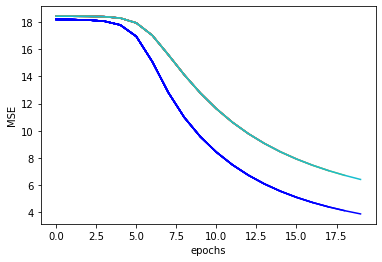

In [53]:
Rec_v.train()

In [ ]:
svd = SVD(lr=0.001, reg=0.005, n_epochs=100, n_factors=15,
         early_stopping=True, shuffle=False, min_rating=1, max_rating=5)
svd.fit(X=df, X_val=df)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 1.31 - val_rmse: 1.14 - val_mae: 0.87 - took 0.1 sec
Epoch 2/100  | val_loss: 1.25 - val_rmse: 1.12 - val_mae: 0.85 - took 0.0 sec
Epoch 3/100  | val_loss: 1.21 - val_rmse: 1.10 - val_mae: 0.83 - took 0.0 sec
Epoch 4/100  | val_loss: 1.18 - val_rmse: 1.09 - val_mae: 0.82 - took 0.0 sec
Epoch 5/100  | val_loss: 1.16 - val_rmse: 1.08 - val_mae: 0.81 - took 0.0 sec
Epoch 6/100  | val_loss: 1.14 - val_rmse: 1.07 - val_mae: 0.81 - took 0.0 sec
Epoch 7/100  | val_loss: 1.13 - val_rmse: 1.06 - val_mae: 0.80 - took 0.0 sec
Epoch 8/100  | val_loss: 1.11 - val_rmse: 1.06 - val_mae: 0.79 - took 0.0 sec
Epoch 9/100  | val_loss: 1.10 - val_rmse: 1.05 - val_mae: 0.79 - took 0.0 sec
Epoch 10/100 | val_loss: 1.09 - val_rmse: 1.04 - val_mae: 0.78 - took 0.0 sec
Epoch 11/100 | val_loss: 1.08 - val_rmse: 1.04 - val_mae: 0.78 - took 0.0 sec
Epoch 12/100 | val_loss: 1.07 - val_rmse: 1.04 - val_mae: 0.77 - took 0.0 sec
Epoch 13/100 | val

In [ ]:
mf_real=MF(data=R, learning_rate=0.01,latent_features=3,beta=0.01,iterations=10)


In [ ]:
mf_real.train()

In [ ]:
mf_real.whole_matrix()

In [ ]:
4**2

In [ ]:
s=np.random.randint(low=1,high=2,size=(3,2))
s1=np.random.uniform(low=5,high=20,size=(2,3))


In [ ]:
s1

In [ ]:
s1[:,0]

In [ ]:
s1[:,0][:]

In [ ]:
samples = [
            (i, j, an[i, j])
            for i in range(3)
            for j in range(3)
        ]
samples

In [ ]:
np.sum((p-an)**2)

In [ ]:
an=np.matmul(s,s1)
an

In [ ]:
results = cross_validate(SVD(), data, measures=['RMSE'], cv=3, verbose=False)
results

In [ ]:
trainset = data.build_full_trainset()

In [ ]:
algo = SVD(n_factors=10, n_epochs=10)
model = algo.fit(trainset)
accuracy.rmse(predictions)
#pred = algo.predict(str(196) , str(302), r_ui=4, verbose=True)


In [ ]:
#df_sample=df1[df1['anonymous_user_id'].isin(s['anonymous_user_id'])]
#print(df_sample.shape)
matrix = df.pivot_table(index='anonymous_user_id', columns='movie_id', values='converted_rating')
print(matrix.shape)
matrix.head()


In [ ]:
user_similarity = matrix.T.corr()
user_similarity

In [ ]:
picked_userid = 5
# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)
# Take a look at the data


In [ ]:
n = 10
# User similarity threashold
user_similarity_threshold = 0
# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]
# Print out top n similar users
#print(f'The similar users for user {picked_userid} are', similar_users)
similar_users

In [ ]:
picked_userid_watched = matrix[matrix.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

In [ ]:
similar_user_movies = matrix[matrix.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

In [ ]:
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
# Take a look at the data
similar_user_movies

In [ ]:
item_score = {}
for i in similar_user_movies.columns:
    movie_rating = similar_user_movies[i]
    total = 0
    count = 0
    for u in similar_users.index:
        if pd.isna(movie_rating[u]) == False:
            score = similar_users[u] * movie_rating[u]
            total += score
            count +=1
    item_score[i] = total / count
    


In [ ]:
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
init_rating = item_score.sort_values(by='movie_score', ascending=False)
# Select top m movies
init_rating

In [ ]:
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]
init_rating['predicted_rating'] = init_rating['movie_score'] + avg_rating
# Take a look at the data
init_rating.head()
